# Wide Deep Network

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 7.0 MB/s 
     |████████████████████████████████| 61 kB 10.6 MB/s 
     |████████████████████████████████| 197 kB 74.8 MB/s 
     |████████████████████████████████| 310 kB 74.3 MB/s 
     |████████████████████████████████| 4.7 MB 86.2 MB/s 
     |████████████████████████████████| 12.4 MB 43.1 MB/s 
     |████████████████████████████████| 11.8 MB 70.8 MB/s 
     |████████████████████████████████| 355 kB 67.6 MB/s 
     |████████████████████████████████| 636 kB 86.5 MB/s 
     |████████████████████████████████| 390 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 84.7 MB/s 
     |████████████████████████████████| 120 kB 77.6 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705359 sha256=fd3c611e5af74172f75c149cbb36b40cc3d760077a00da48fe3e398ea2277c6d
  Stored in directory: /root/.cache/pip/wh

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split,python_stratified_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 2.8.2
GPUs:
 [{'device_name': 'Tesla P100-PCIE-16GB', 'total_memory': 16280.875, 'free_memory': 16025.75}]


### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-

Downloading...
From: https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-
To: /content/Books.zip
100% 25.0M/25.0M [00:00<00:00, 177MB/s] 


In [ ]:
!unzip "Books.zip"  -d  "/content"

Archive:  Books.zip
  inflating: /content/Books.csv      
  inflating: /content/Ratings.csv    
  inflating: /content/Users.csv      


In [ ]:
rating_df = pd.read_csv('Ratings.csv')
book_df = pd.read_csv('Books.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


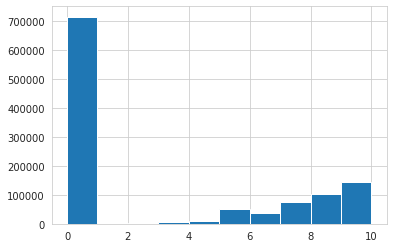

In [ ]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df['Book-Rating'].hist()

In [ ]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=100
books = y[y].index
rating_df = rating_df[rating_df['Book-Title'].isin(books)]

In [ ]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 100
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]


In [ ]:
rating_df=rating_df.dropna()

In [ ]:
rating_df=rating_df[['User-ID','Book-Title','Book-Author','Book-Rating']]
rating_df.rename(columns = {'User-ID':'userID', 'Book-Title':'itemID','Book-Author':'author','Book-Rating':'rating'}, inplace = True)

In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)
rating_df["author"] = rating_df["author"].astype(str)

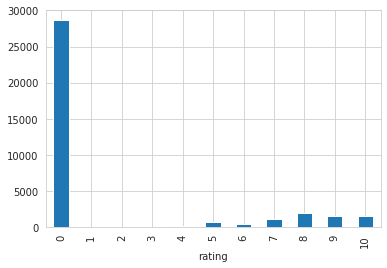

In [ ]:
rating_df.groupby(['rating']).size().plot(kind = "bar")

Parameters

In [ ]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [ ]:
data=rating_df

In [ ]:
ITEM_FEAT_COL="author"

 Encode Item Features

In [ ]:
import sklearn.preprocessing
author_encoder = sklearn.preprocessing.MultiLabelBinarizer()
data[ITEM_FEAT_COL] = author_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
print("authors:", author_encoder.classes_)
display(data.head())

Genres: ['A. Manette Ansay' 'A.S. BYATT' 'ALBERT CAMUS' 'ANN BRASHARES'
 'ANN PACKER' 'ANNA QUINDLEN' 'ANNE FRANK' 'ANNE RICE' 'ANNE TYLER'
 'Adriana Trigiani' 'Al Franken' 'Alan Lightman' 'Alan Rodgers'
 'Albert Camus' 'Aldous Huxley' 'Alex Garland' 'Alexander McCall Smith'
 'Alexandra Ripley' 'Alice Hoffman' 'Alice McDermott' 'Alice Mcdermott'
 'Alice Sebold' 'Alice Walker' 'Alison Fraser' 'Alton Gansky' 'Amy Tan'
 'Andre Dubus III' 'Anita Diamant' 'Anita Mills' 'Anita Shreve'
 'Ann B. Ross' 'Ann Patchett' 'Ann Rule' 'Ann-Marie MacDonald'
 'Anna Aaron' 'Anna Quindlen' 'Anne Rice' 'Anne Tyler' 'Annie Proulx'
 'Anonymous' 'Antoine de Saint-ExupÃ©ry' 'Antoinette Stockenberg'
 'Archer Mayor' 'Arlene Eisenberg' 'Arthur Golden' 'Arundhati Roy'
 'Augusten Burroughs' 'Author Unknown' 'Ayn Rand' 'BELVA PLAIN'
 'BERTRICE SMALL' 'Banana Yoshimoto' 'Barbara Cartland' 'Barbara Delinsky'
 'Barbara Ehrenreich' 'Barbara Gowdy' 'Barbara Kingsolver' 'Belva Plain'
 'Benjamin Hoff' 'Bernhard Schlink' 'B

,userID,itemID,author,rating
1456,277427,Politically Correct Bedtime Stories: Modern Ta...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
1468,277427,A Tree Grows in Brooklyn,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1469,277427,The Poisonwood Bible: A Novel,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1471,277427,Bel Canto: A Novel,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1474,277427,One for the Money (Stephanie Plum Novels (Pape...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9


### Prepare dataset

In [ ]:
train, test = python_random_split(data, ratio=0.8, seed=RANDOM_SEED)
print("{} train samples and {} test samples".format(len(train), len(test)))

29122 train samples and 7281 test samples


In [ ]:
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 914 items and 211 users in the dataset


In [ ]:
save_checkpoints_steps = max(1, STEPS // 5)


In [ ]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=100,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=('277427', '278418', '3363', '6251', ' ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=('Politically Correct Bedtime Stories: ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=('277427', '278418 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=('2 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=('P ...
	 NumericColumn(key='author', shape=(593,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


### Prepare dataset for tensorflow recommenders

In [ ]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=None,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

In [ ]:
USER_COL="userID"
ITEM_COL="itemID"
RATING_COL="rating"
PREDICT_COL="prediction"

In [ ]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [ ]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=None,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [ ]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Training steps = 50000, Batch size = 32 (num epochs = 54)


INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpaqxltb4p/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 700.66675, step = 0
INFO:tensorflow:global_step/sec: 11

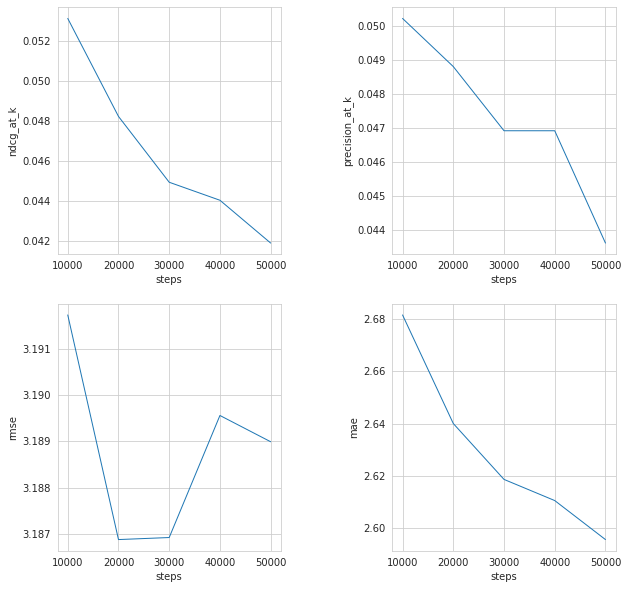

In [ ]:
import math
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
       
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

Evaluation

In [ ]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        #sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaqxltb4p/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 3.1889909841444326, 'mae': 2.595706663202167}


In [ ]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaqxltb4p/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.04189446597101718, 'precision_at_k': 0.04360189573459714}
